In [4]:
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)
np.random.seed(0)


In [5]:
from replay_identification.simulate import make_simulated_data

(is_replay, speed, position, power, spikes, time, multiunit) = make_simulated_data()


INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


In [6]:
from replay_identification.detectors import SortedSpikesDetector

detector = SortedSpikesDetector(
    random_walk_variance=6.0,
    place_bin_size=2.0,
    continuous_state_transition_type="random_walk",
    discrete_state_transition_type="make_from_user_specified_diagonal"
)
detector


SortedSpikesDetector(continuous_state_transition_type='random_walk',
                     discrete_state_transition_type='make_from_user_specified_diagonal',
                     discrete_transition_diagonal=array([0.999, 0.98 ]),
                     edge_order=None, edge_spacing=None,
                     infer_track_interior=True, is_track_interior=None,
                     place_bin_size=2.0, position_range=None,
                     random_walk_variance=6.0,
                     sorted_spikes_algorithm='spiking_likelihood_kde',
                     sorted_spikes_algorithm_params={'block_size': None,
                                                     'position_std': 6.0},
                     track_graph=None)

In [7]:
detector.fit(position, spikes, ~is_replay)


INFO:replay_identification.detectors:Fitting discrete state transition...
INFO:replay_identification.detectors:Fitting continuous state transition...
INFO:replay_identification.detectors:Fitting place fields...


SortedSpikesDetector(continuous_state_transition_type='random_walk',
                     discrete_state_transition_type='make_from_user_specified_diagonal',
                     discrete_transition_diagonal=array([0.999, 0.98 ]),
                     edge_order=None, edge_spacing=None,
                     infer_track_interior=True, is_track_interior=None,
                     place_bin_size=2.0, position_range=None,
                     random_walk_variance=6.0,
                     sorted_spikes_algorithm='spiking_likelihood_kde',
                     sorted_spikes_algorithm_params={'block_size': None,
                                                     'position_std': 6.0},
                     track_graph=None)

In [8]:
results = detector.predict(position, spikes, time=time)
results


INFO:replay_identification.detectors:Estimating likelihood...


  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...


<xarray.Dataset>
Dimensions:                (time: 97500, state: 2, position: 86)
Coordinates:
  * time                   (time) float64 0.0 0.0006667 0.001333 ... 65.0 65.0
  * position               (position) float64 0.9881 2.965 4.942 ... 167.0 169.0
  * state                  (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior       (time, state, position) float64 1.0 0.0 ... 1.586e-05
    likelihood             (time, state, position) float32 0.9972 ... 0.996
    acausal_posterior      (time, state, position) float64 1.0 0.0 ... 1.586e-05
    non_local_probability  (time) float64 0.0 0.0007595 ... 0.02529 0.02573
Attributes:
    data_log_likelihood:  -904.7149215740666

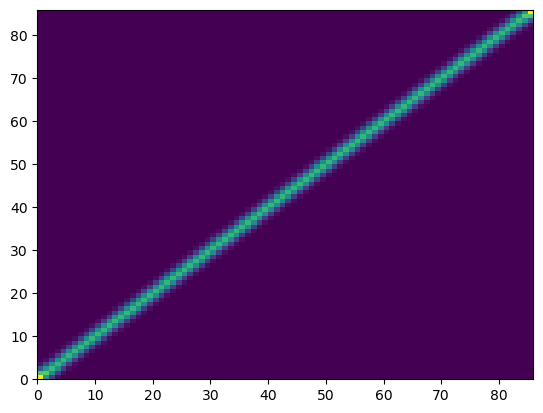

In [9]:
detector.plot_continuous_state_transition()


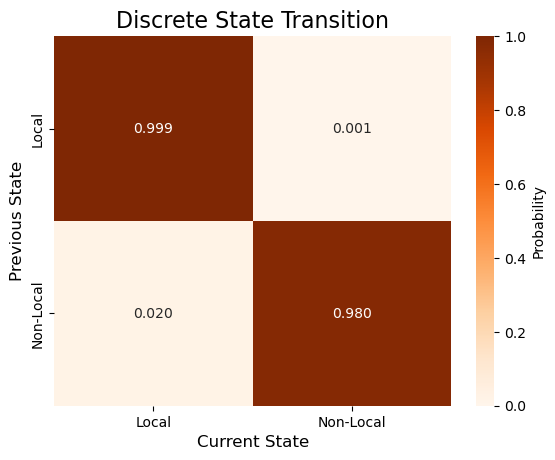

In [10]:
detector.plot_discrete_state_transition()


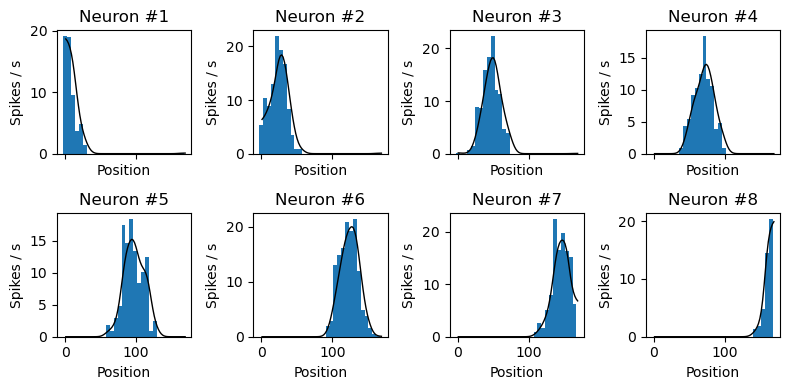

In [11]:
axes = detector.plot_spikes(position, spikes, is_training=~is_replay, sampling_frequency=1500, col_wrap=4);
detector.plot_place_fields(sampling_frequency=1500, col_wrap=4, axes=axes)

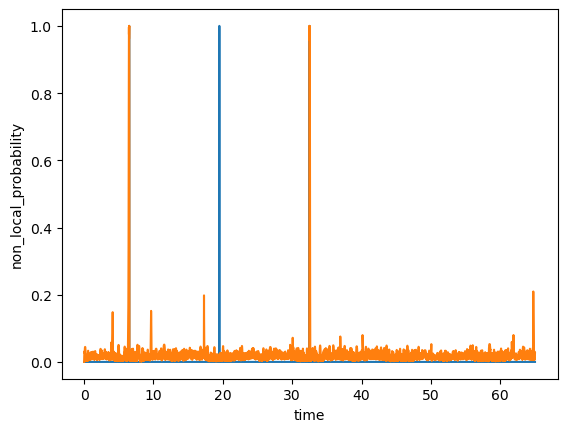

In [12]:
plt.plot(time, is_replay)
results.non_local_probability.plot(x='time')

In [13]:
is_track_interior = detector.is_track_interior_.ravel(order="F")
n_position_bins = len(is_track_interior)
is_states = np.ones((2,), dtype=bool)
st_interior_ind = np.ix_(
    is_states, is_states, is_track_interior, is_track_interior
)


In [26]:
c = detector.continuous_state_transition_
u = np.ones_like(c) / c.shape[0]
i  = np.zeros_like(c)
i[:, 0] = 1

In [27]:
cst = [[c, u],
       [u, i]]

max_pos_bins_ = detector.continuous_state_transition_.shape[0]

continuous_state_transition = np.zeros(
            (n_states, n_states, max_pos_bins_, max_pos_bins_)
        )
for row_ind, row in enumerate(cst):
    for column_ind, st in enumerate(row):
        continuous_state_transition[row_ind, column_ind, : st.shape[0], : st.shape[1]] = st

continuous_state_transition.shape

(2, 2, 86, 86)

In [29]:
from replay_trajectory_classification.core import _causal_classify, _acausal_classify
from replay_identification.detectors import get_observed_position_bin

n_time = len(results.time)
n_states = 2
n_position_bins = len(detector.place_bin_centers_)

observed_position_bin = get_observed_position_bin(
    position[:, np.newaxis],
    detector.edges_,
    detector.place_bin_centers_,
    detector.is_track_interior_.ravel(order='F')
)

likelihood = results.likelihood.values[..., np.newaxis]

initial_conditions = np.zeros((n_states, n_position_bins))
initial_conditions[0, observed_position_bin[0]] = 1

r = dict()
r["causal_posterior"] = np.full(
    (n_time, n_states, n_position_bins, 1), np.nan, dtype=np.float64
)
(
    r["causal_posterior"][:, :, is_track_interior],
    data_log_likelihood,
) = _causal_classify(
    initial_conditions[:, is_track_interior].astype(np.float64),
    continuous_state_transition[st_interior_ind].astype(
        np.float64
    ),
    detector.discrete_state_transition_.astype(np.float64),
    likelihood[:, :, is_track_interior].astype(np.float64),
)